In [3]:
import numpy as np
import glob as gb
import matplotlib.pyplot as plt
import random
import os
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

In [4]:
#CONSTANTS
dataset_test_path ="./dataset_new/test/"
dataset_train_path ="./dataset_new/train/"
label_values = ['closed', 'open','no_yawn','yawn']

In [5]:
"""
Function for loading images from the dataset and preprocessing and storing
arrays of images and img_labels
"""

def load_and_preprocess_img(path):

    images=[]
    img_labels=[]    
    cat_closed=[]
    cat_no_yawn=[]
    cat_open=[]
    cat_yawn=[]

    for category in os.listdir(path): 
        files = gb.glob(pathname= str( path + category + '/*.jpg'))
        print(f'Found {len(files)} images in category {category}')
        for img_path in files:
            #Load img
            img = cv2.imread(img_path)
            #Resize img
            img = cv2.resize(img, (128,128))
            #Convert img to grayscale
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            #Normalize pixel values 
            img = img.astype('float32') / 255.0 
            #add img to list
            images.append(img)

            #Set labels
            if category == 'Closed':
                img_labels.append(0)
                cat_closed.append(img)

            elif category== 'Open':
                img_labels.append(1)
                cat_open.append(img)

            elif category== 'no_yawn':
                img_labels.append(2)
                cat_no_yawn.append(img)

            elif category== 'yawn':
                img_labels.append(3)
                cat_yawn.append(img)

            else:
                #default
                img_labels.append(-1)

    if np.any(img_labels == -1):
        print("ERROR one of the img wasnt labeled")
    else:
        print("For path " + path + " images were proccesed correctly! ✔")

    return np.array(images,dtype='float32'),np.array(img_labels), np.array(cat_closed),np.array(cat_open),np.array(cat_no_yawn),np.array(cat_yawn)

In [6]:
"""
Function for showing random images with labels
"""
def show_img_label(images,labels):
    label_values = ['closed', 'open','no_yawn','yawn']
    #Number of img to show
    num_images=30
    rows=6
    cols=5

    # Randomly select unique indices for images
    indices = np.random.choice(len(images),num_images, replace=False)
    
    fig = plt.figure(figsize=(9, 10))
    
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(label_values[labels[idx]])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [7]:
#Get processed img
train_dataset = load_and_preprocess_img(dataset_train_path)

Found 617 images in category Closed
Found 616 images in category no_yawn
Found 617 images in category Open
Found 617 images in category yawn
For path ./dataset_new/train/ images were proccesed correctly! ✔


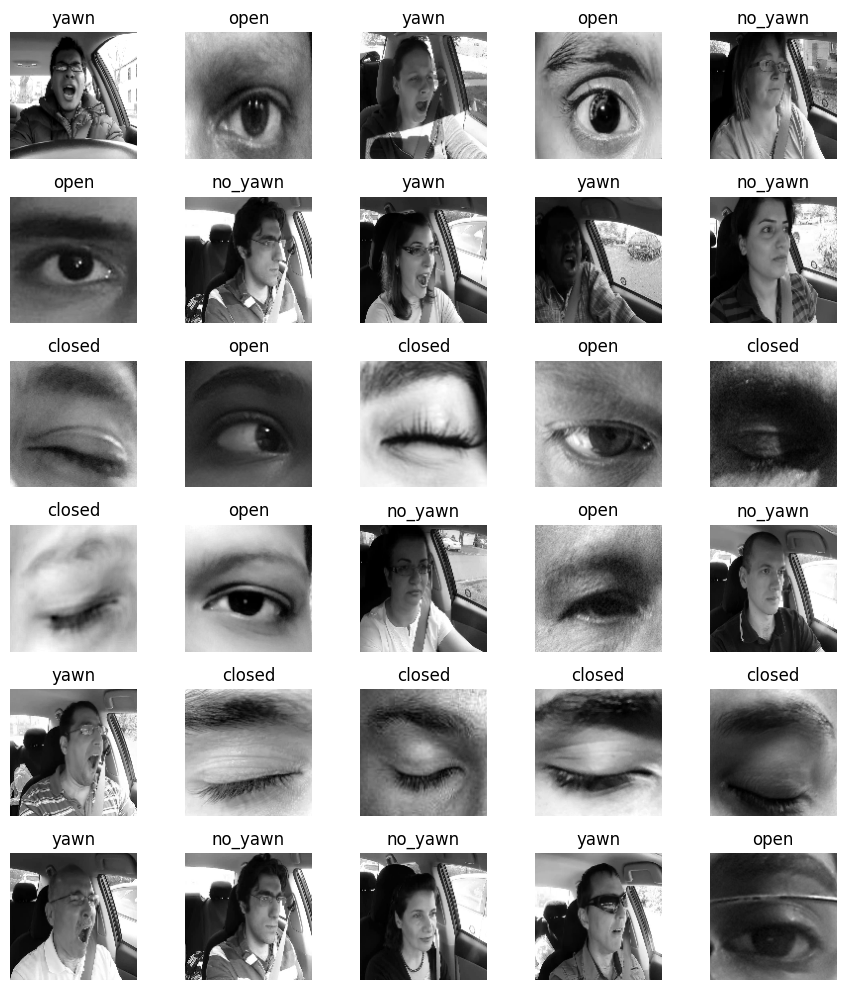

In [74]:
#SHOW IMAGES WITH LABELS
show_img_label(train_dataset[0],train_dataset[1])

In [9]:
"""
Split train data set int to validation and train dataset!

test_size=0.2 specifies that 20% of the data will be allocated for validation.
random_state=42 sets the random seed for reproducibility.

"""

train_val, validation_val, train_label , validation_label = train_test_split(train_dataset[0],train_dataset[1], test_size=0.2, random_state=42)

print("train size is: " + str(len(train_val)) + ", " + str(len(train_label)) )
print("validation size is: " + str(len(validation_val)) + ", " + str(len(validation_label)) )


train size is: 1973, 1973
validation size is: 494, 494


In [10]:
"""
Initialization of a cnn model
"""
def init_model():
    # Define a Sequential
    model = models.Sequential()
    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel size, ReLU activation, and input shape of (128, 128, 1) for grayscale images
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # Add another 2D convolutional layer with 64 filters and a 3x3 kernel size
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # Add a third 2D convolutional layer with 128 filters and a 3x3 kernel size
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten the output from the convolutional layers into a 1D array
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    # Add a dense layer with 256 units and ReLU activation
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    # Add a dense output layer with 4 units and softmax activation for multi-class classification
    model.add(layers.Dense(4, activation='softmax'))

    return model

In [12]:
# Initialize the model
model = init_model()
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [13]:
"""
Train the model
"""
# Train the model with 8epochs
history = model.fit(train_val, train_label, epochs=8, validation_data=(validation_val, validation_label))

Epoch 1/8
62/62 [==============================] - 60s 893ms/step - loss: 3.8810 - accuracy: 0.6974 - val_loss: 27.5130 - val_accuracy: 0.2692
Epoch 2/8
62/62 [==============================] - 54s 866ms/step - loss: 1.4237 - accuracy: 0.7785 - val_loss: 39.1723 - val_accuracy: 0.2510
Epoch 3/8
62/62 [==============================] - 53s 846ms/step - loss: 0.9405 - accuracy: 0.7805 - val_loss: 34.8055 - val_accuracy: 0.2490
Epoch 4/8
62/62 [==============================] - 52s 837ms/step - loss: 0.6439 - accuracy: 0.7942 - val_loss: 25.2963 - val_accuracy: 0.3360
Epoch 5/8
62/62 [==============================] - 51s 825ms/step - loss: 0.5766 - accuracy: 0.8120 - val_loss: 28.7792 - val_accuracy: 0.3947
Epoch 6/8
62/62 [==============================] - 51s 820ms/step - loss: 0.5006 - accuracy: 0.8327 - val_loss: 22.3502 - val_accuracy: 0.3806
Epoch 7/8
62/62 [==============================] - 50s 801ms/step - loss: 0.5364 - accuracy: 0.8393 - val_loss: 1.2464 - val_accuracy: 0.6984


In [79]:
"""
Function to analyze accuracy
"""
def analyze_chart(history):
    plt.figure(figsize=(20,10))
    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

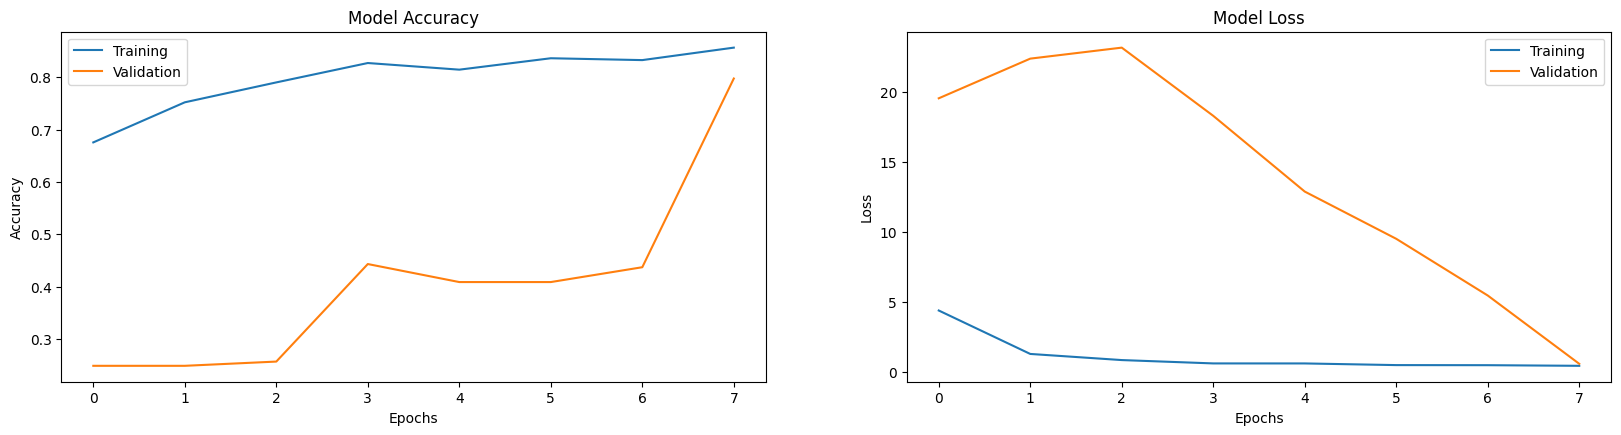

In [80]:
analyze_chart(history)

In [81]:
""" 
Get test dataset
"""
#Get processed img
test_dataset = load_and_preprocess_img(dataset_test_path)

Found 109 images in category Closed
Found 109 images in category no_yawn
Found 109 images in category Open
Found 106 images in category yawn
For path ./dataset_new/test/ images were proccesed correctly! ✔


In [82]:
# Evaluate the model on the test dataset
test_images=np.array(test_dataset[0])
test_labels=np.array(test_dataset[1])

#TRAINING DATASET


In [83]:
""" 
Get accuracy for each category
"""
def accuracy_per_category():
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)

    # Get the predicted labels for the test dataset
    predicted_labels = model.predict(test_images)
    predicted_indices = np.argmax(predicted_labels, axis=1)

    # Calculate the accuracy for each category
    categories = np.unique(test_labels)
    category_accuracy = {}

    for category in categories:
        category_indices = np.where(test_labels == category)[0]
        category_true_labels = test_labels[category_indices]
        category_predicted_labels = predicted_indices[category_indices]
        category_accuracy[category] = accuracy_score(category_true_labels, category_predicted_labels)

    # Print the overall test accuracy
    print("Test Accuracy:", test_accuracy)

    # Print the accuracy for each category
    for category, accuracy in category_accuracy.items():
        print(f"Accuracy for category {label_values[category]}: {accuracy} %")

In [84]:
predictions = model.predict(test_images) 
test_loss, test_accuracy = model.evaluate(test_images,test_labels)
accuracy_per_category()

14/14 [==============================] - 3s 183ms/step
Test Accuracy: 0.7829099297523499
Accuracy for category closed: 0.7706422018348624 %
Accuracy for category open: 0.926605504587156 %
Accuracy for category no_yawn: 0.908256880733945 %
Accuracy for category yawn: 0.5188679245283019 %


##Ker smo ugotovili da je natančnost za kategorijo 'yawn' premala, sem se odločil povečati dataset, z augmentacijo podatkov

In [17]:
"""
Train the model with more epochs!
"""
# Train the model with 16epochs
history = model.fit(train_val, train_label, epochs=16, validation_data=(validation_val, validation_label))


Epoch 1/16
62/62 [==============================] - 52s 821ms/step - loss: 0.3593 - accuracy: 0.8647 - val_loss: 0.4532 - val_accuracy: 0.8239
Epoch 2/16
62/62 [==============================] - 50s 813ms/step - loss: 0.3350 - accuracy: 0.8586 - val_loss: 0.5396 - val_accuracy: 0.8279
Epoch 3/16
62/62 [==============================] - 50s 806ms/step - loss: 0.3248 - accuracy: 0.8758 - val_loss: 0.2760 - val_accuracy: 0.8664
Epoch 4/16
62/62 [==============================] - 47s 756ms/step - loss: 0.3445 - accuracy: 0.8748 - val_loss: 0.2793 - val_accuracy: 0.8826
Epoch 5/16
62/62 [==============================] - 52s 838ms/step - loss: 0.2743 - accuracy: 0.8779 - val_loss: 0.3755 - val_accuracy: 0.8522
Epoch 6/16
62/62 [==============================] - 49s 787ms/step - loss: 0.3101 - accuracy: 0.8890 - val_loss: 0.2462 - val_accuracy: 0.9069
Epoch 7/16
62/62 [==============================] - 48s 775ms/step - loss: 0.2538 - accuracy: 0.8870 - val_loss: 0.3339 - val_accuracy: 0.8947

In [21]:
"""
Function for showing random images with labels for predictions
"""
def show_img_label_prediction(images,labels):
    label_values = ['closed', 'open','no_yawn','yawn']
    #Number of img to show
    num_images=30
    rows=6
    cols=5

    # Randomly select unique indices for images
    indices = np.random.choice(len(images),num_images, replace=False)
    
    fig = plt.figure(figsize=(9, 10))
    
    for i, idx in enumerate(indices):
        print()
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(label_values[np.argmax([labels[idx]])])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

14/14 [==============================] - 2s 169ms/step


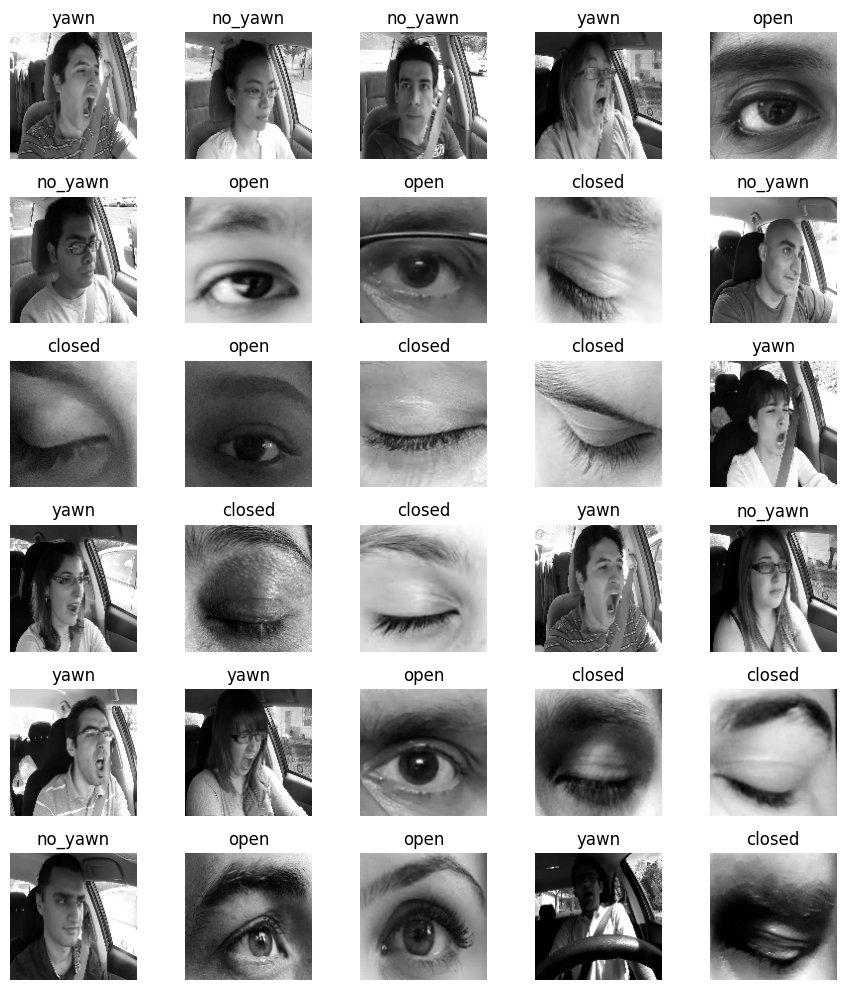

14/14 [==============================] - 3s 187ms/step
Test Accuracy: 0.9191685914993286
Accuracy for category closed: 0.963302752293578 %
Accuracy for category open: 0.9357798165137615 %
Accuracy for category no_yawn: 0.8990825688073395 %
Accuracy for category yawn: 0.8773584905660378 %


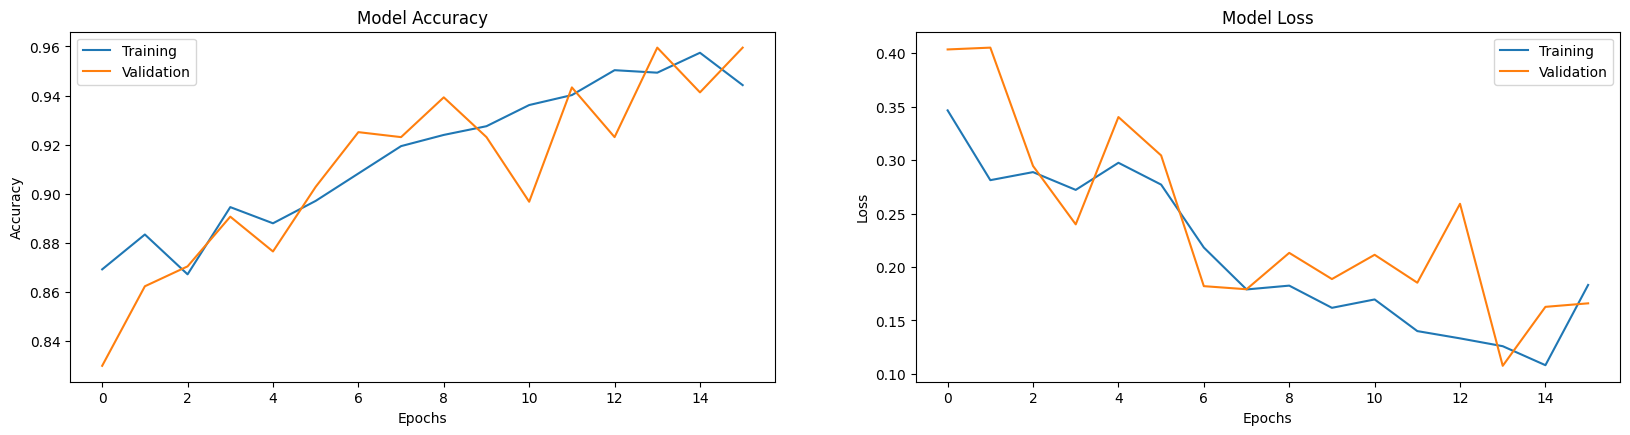

In [ ]:
predictions = model.predict(test_images) 
show_img_label_prediction(test_images, predictions)
test_loss, test_accuracy = model.evaluate(test_images,test_labels)
accuracy_per_category()
analyze_chart(history)


INCREASING NUMBER OF DATASETS WITH AUGMENTATION

In [162]:
""" 
Function that takes images and augmentates into x images
"""
def augment_images(images, label):
    augmented_images = []
    augmented_labels=[]
    
    for image in images:
        # Original image
        augmented_images.append(image)
        augmented_labels.append(label)
        for x in range(3):
            # Randomly flip horizontally
            if np.random.random() < 0.5:
                aug_image1 = cv2.flip(image, 1)
            else:
                aug_image1 = image.copy()
            
            # Randomly rotate
            angle = np.random.randint(-40, 40)
            rows, cols = aug_image1.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
            aug_image1 = cv2.warpAffine(aug_image1, M, (cols, rows))
            
            # Randomly blur
            if np.random.random() < 0.5:
                aug_image1 = cv2.GaussianBlur(aug_image1, (5, 5), 0)            
            augmented_images.append(aug_image1)    
            augmented_labels.append(label)
    return np.array(augmented_images,dtype='float32'), np.array(augmented_labels)
        

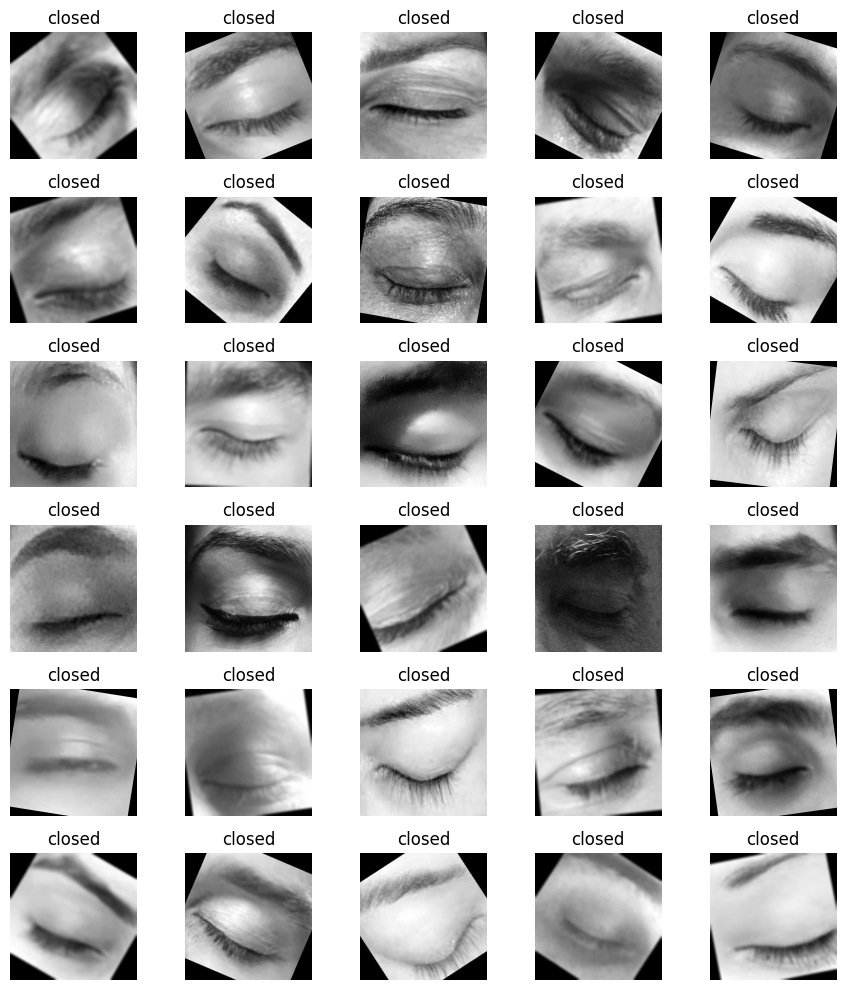

In [163]:
cat = augment_images(train_dataset[2],0)
show_img_label(cat[0], cat[1])

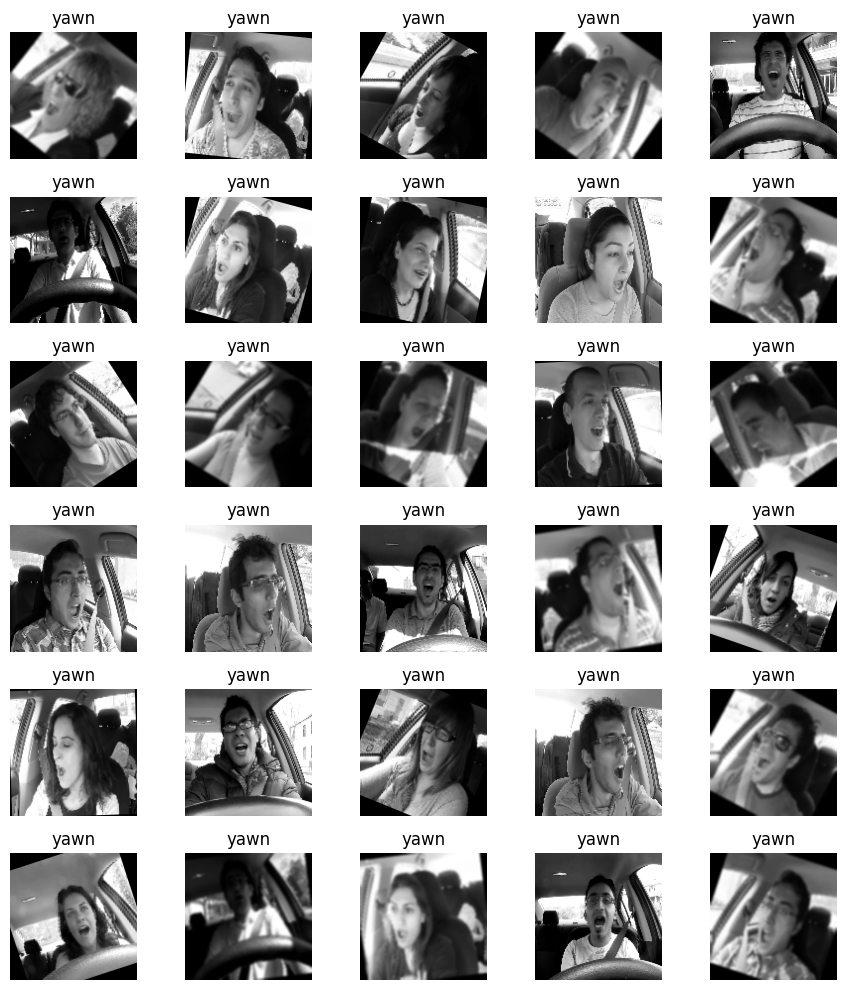

New augm size is: 9868 9868


In [170]:
cat_closed = augment_images(train_dataset[2],0)
cat_no_yawn = augment_images(train_dataset[3],1)
cat_open = augment_images(train_dataset[4],2)
cat_yawn = augment_images(train_dataset[5],3)
show_img_label(cat_yawn[0], cat_yawn[1])

augm_img = np.concatenate((cat_closed[0],cat_no_yawn[0],cat_open[0],cat_yawn[0]))
augm_labels = np.concatenate((cat_closed[1],cat_no_yawn[1],cat_open[1],cat_yawn[1]))
print("New augm size is: " + str(len(augm_img)) +" "+ str(len(augm_labels)))

In [172]:
"""
Train the model with bigger dataset!
"""
# Train the model with 8epochs
history = model.fit(augm_img, augm_labels, epochs=8, validation_data=(validation_val, validation_label))

Epoch 1/8
309/309 [==============================] - 334s 1s/step - loss: 0.3485 - accuracy: 0.8359 - val_loss: 0.2081 - val_accuracy: 0.9372
Epoch 2/8
309/309 [==============================] - 300s 970ms/step - loss: 0.2975 - accuracy: 0.8549 - val_loss: 0.0948 - val_accuracy: 0.9757
Epoch 3/8
309/309 [==============================] - 294s 950ms/step - loss: 0.2966 - accuracy: 0.8550 - val_loss: 0.0896 - val_accuracy: 0.9656
Epoch 4/8
309/309 [==============================] - 252s 816ms/step - loss: 0.2772 - accuracy: 0.8744 - val_loss: 0.1815 - val_accuracy: 0.9514
Epoch 5/8
309/309 [==============================] - 325s 1s/step - loss: 0.2651 - accuracy: 0.8836 - val_loss: 0.0432 - val_accuracy: 0.9899
Epoch 6/8
309/309 [==============================] - 350s 1s/step - loss: 0.2244 - accuracy: 0.8941 - val_loss: 0.0644 - val_accuracy: 0.9818
Epoch 7/8
309/309 [==============================] - 330s 1s/step - loss: 0.2200 - accuracy: 0.9004 - val_loss: 0.0381 - val_accuracy: 0.98

14/14 [==============================] - 2s 162ms/step


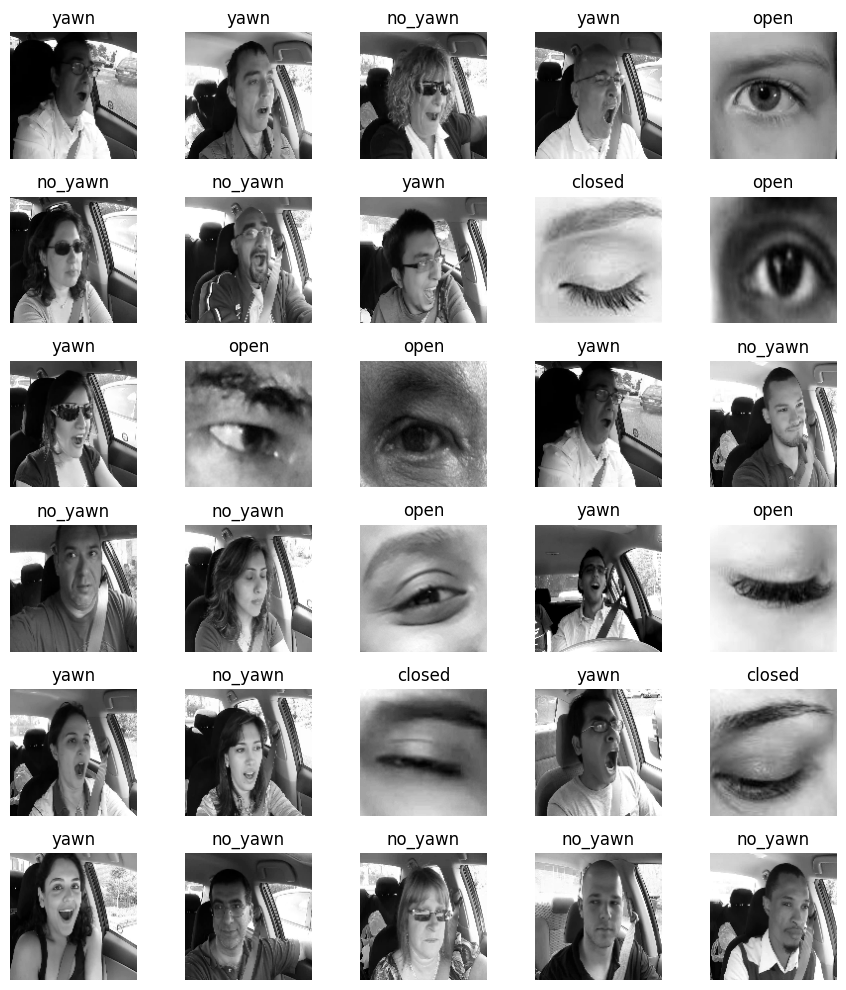

14/14 [==============================] - 3s 200ms/step
Test Accuracy: 0.9191685914993286
Accuracy for category closed: 0.8990825688073395 %
Accuracy for category open: 0.981651376146789 %
Accuracy for category no_yawn: 0.981651376146789 %
Accuracy for category yawn: 0.8113207547169812 %


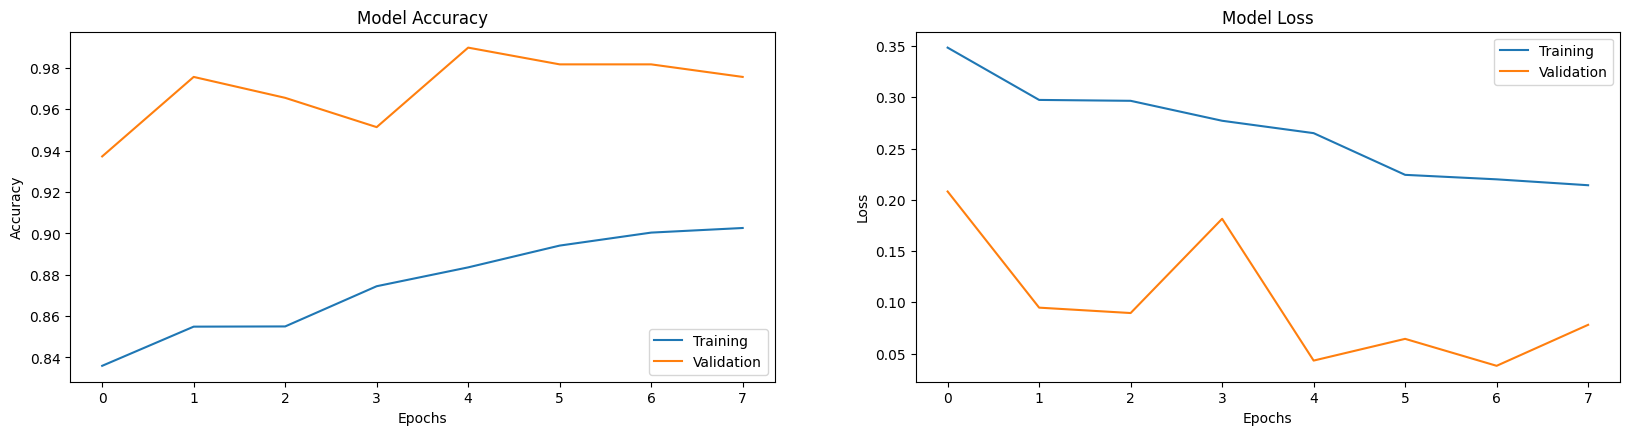

In [173]:
predictions = model.predict(test_images) 
show_img_label_prediction(test_images, predictions)
test_loss, test_accuracy = model.evaluate(test_images,test_labels)
accuracy_per_category()
analyze_chart(history)

## Testing model on my images


In [18]:
folder_path = "moje_slike/"  # Relative path to the folder containing your images

# Get the list of image file names in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

my_images=[]

# Read and process each image
for file_name in image_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)
    
    # Read the image
    img = cv2.imread(file_path)

    img = cv2.resize(img, (128,128))

    #Convert img to grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #Normalize pixel values 
    img = img.astype('float32') / 255.0 
    #add img to list
    my_images.append(img) 

my_images = np.array(my_images,dtype='float32')
   

1/1 [==============================] - 0s 51ms/step
Line 1: 0.983357310295105
Line 2: 0.9903483390808105
Line 3: 1.0
[1.06742965e-20 4.36395413e-31 1.66426748e-02 9.83357310e-01
 0.00000000e+00 0.00000000e+00]
biggest one is
[5.6768760e-26 7.3714884e-27 9.9034834e-01 9.6516302e-03 4.7089292e-21
 2.3461317e-27]
biggest one is
[1.0000000e+00 6.6414305e-12 2.6065900e-36 6.3185086e-37 1.8647433e-37
 1.6264857e-26]
biggest one is


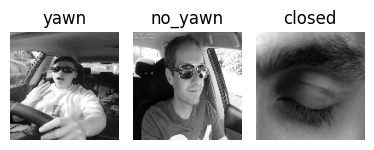

In [19]:
# Make predictions on test images
predictions = model.predict(my_images)

label_values = ['closed', 'open','no_yawn','yawn']
    #Number of img to show
num_images=len(my_images)
rows=2
cols=8

fig = plt.figure(figsize=(10, 8))

# Find the index of the largest value in each line
max_indices = np.argmax(predictions, axis=1)

# Print the largest value in each line
for i in range(len(predictions)):
    max_value = predictions[i][max_indices[i]]
    print(f"Line {i+1}: {max_value}")

for i in range(num_images):
    print(predictions[i])
    print("biggest one is")
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(my_images[i], cmap='gray')
    prediction_index = np.argmax(predictions[i])  # Get the index of the highest predicted value
    print
    ax.set_title(label_values[prediction_index])
    ax.axis('off')

plt.tight_layout()
plt.show()
